In [1]:
%matplotlib widget

In [1]:
import sys
sys.path.append("..")
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from data.loaders import load_capas_from_jsons, get_train_test_data, extract_capa_for_model
from catboost import CatBoost, CatBoostRegressor, Pool
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm


In [101]:
base_dir = r"C:\Users\stav\data\whodis\parsed\CAPAs"
train_test_split_dir = r'C:\Users\stav\data\whodis\train_test_split'

In [102]:
cat_dfs= load_capas_from_jsons(base_dir)
capas_df = cat_dfs['capas']
mbcs_df = cat_dfs['mbc']
features_encoder = LabelEncoder(); features_encoder.fit(capas_df['rule'].append(mbcs_df['objective']))
capas_df['rule'] = features_encoder.transform(capas_df.rule).astype(str)
mbcs_df['objective']=features_encoder.transform(mbcs_df.objective).astype(str)

Loading json files: 100%|███████████████████████████████████████████████████████| 11075/11075 [00:14<00:00, 783.18it/s]


In [7]:
# Prepare features
capas_features_df = extract_capa_for_model(capas_df, column='rule')
mbcs_features_df = extract_capa_for_model(mbcs_df,column='objective')

In [12]:
features_opts = 'both' #['capas','mbc','both']
if features_opts=='both':
    features_df = pd.concat([capas_features_df,mbcs_features_df.drop(columns=['label'])],axis=1).fillna(int(0))
    feature_names = features_df.drop(columns=['label']).columns
    features_df[feature_names]=features_df[feature_names].astype(int)
elif features_opts=='capas':
    features_df = capas_features_df
elif features_opts=='mbc':
    features_df = mbcs_features_df
    

In [13]:
features_df['label'].unique()

array(['not_apt', 'missing', 'veno', 'orcus', '7ev3n', 'Emotet', 'Conti',
       'cozy', 'SugarRansomware'], dtype=object)

In [14]:
split_type= 'family_as_bg' #['flat','family_as_bg']
if split_type=='flat':
    pass
elif split_type=='family_as_bg':
    families = ['orcus', '7ev3n', 'Emotet', 'Conti', 'SugarRansomware','not_apt','missing']
    apts = ['cozy','veno']
    
    transform_dict = {f:'family' for f in families}
    for apt in apts:
        transform_dict[apt]=apt
    transform_dict['wipbot']='veno'
    features_df['label'] = features_df.label.apply(transform_dict.get)
    
label_names = features_df['label'].unique()
le = LabelEncoder()
le.fit(features_df.label)
features_df['label'] = le.transform(features_df.label)
label_names

In [14]:
# Ignore Features

ignore_features=['move file']

In [110]:
def _load_split(features_df, split_ver):
    if split_ver=='v3':
        train_split, test_split, hard_test_split = get_train_test_data(train_test_split_dir, ver=split_ver)
        train_index  = np.intersect1d(train_split.index, features_df.index)
        test_index  = np.intersect1d(test_split.index, features_df.index)
        hard_test_index  = np.intersect1d(hard_test_split.index, features_df.index)
        features_train = features_df.loc[train_index]
        features_test = features_df.loc[test_index]
        hard_features_test = features_df.loc[hard_test_index]

    else:
        train_split, test_split = get_train_test_data(train_test_split_dir, ver=split_ver)

        train_index  = np.intersect1d(train_split.index, features_df.index)
        test_index  = np.intersect1d(test_split.index, features_df.index)
        features_train = features_df.loc[train_index]
        features_test = features_df.loc[test_index]
        hard_features_test = pd.DataFrame(columns=features_df.columns)
    return features_train, features_test, hard_features_test

In [111]:
split_ver = 'v3' #['v1,'v2',v3']
features_train, features_test, hard_features_test=_load_split(features_df, split_ver)
selected_features = features_train.drop(['label'].columns                              

In [111]:
X_train = features_train[selected_features]
y_train = features_train.label
X_test = features_test[selected_features]
y_test = features_test.label
X_test_hard = hard_features_test[selected_features]
y_test_hard = hard_features_test.label

In [111]:
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)
hard_test_pool = Pool(X_test_hard, label=y_test_hard)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [44]:
#Basic model params
model_params = dict(iterations=3000, learning_rate=0.1, auto_class_weights='Balanced', reg_lambda=6.0, grow_policy='Lossguide', 
                    depth=12, max_leaves=24, colsample_bylevel=0.5, loss_function='MultiClassOneVsAll')

model = CatBoostClassifier(**model_params)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=True,
    plot=True
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

In [44]:
print('Test Accuracy (Easy) {}'.format((model1.predict(X_test))==y_test).sum()/y_test.shape[0]))
print('Test Accuracy (hard) {}'.format((model1.predict(X_test_hard)==y_test_hard).sum()/y_test_hard.shape[0]))

In [45]:
summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=features_train.drop(columns=['label']).columns.to_list(),     # we will select from all features
        num_features_to_select=100,  # we want to select exactly important features
        steps=5,                                     # more steps - more accurate selection
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Verbose',
        plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 5
0:	learn: 0.6470464	test: 0.6470356	best: 0.6470356 (0)	total: 9.41ms	remaining: 28.2s
1:	learn: 0.6098239	test: 0.6096862	best: 0.6096862 (1)	total: 17.4ms	remaining: 26.1s
2:	learn: 0.5770682	test: 0.5771541	best: 0.5771541 (2)	total: 25.6ms	remaining: 25.6s
3:	learn: 0.5497488	test: 0.5505593	best: 0.5505593 (3)	total: 33.2ms	remaining: 24.9s
4:	learn: 0.5276766	test: 0.5289673	best: 0.5289673 (4)	total: 41.4ms	remaining: 24.8s
5:	learn: 0.5086421	test: 0.5105233	best: 0.5105233 (5)	total: 49.1ms	remaining: 24.5s
6:	learn: 0.4907651	test: 0.4932994	best: 0.4932994 (6)	total: 57.2ms	remaining: 24.5s
7:	learn: 0.4753911	test: 0.4787927	best: 0.4787927 (7)	total: 65.5ms	remaining: 24.5s
8:	learn: 0.4625282	test: 0.4668107	best: 0.4668107 (8)	total: 73.7ms	remaining: 24.5s
9:	learn: 0.4473888	test: 0.4519922	best: 0.4519922 (9)	total: 82.5ms	remaining: 24.7s
10:	learn: 0.4365260	test: 0.4413963	best: 0.4413963 (10)	total: 90.8ms	remaining: 24.7s
11:	learn: 0.4257150	tes

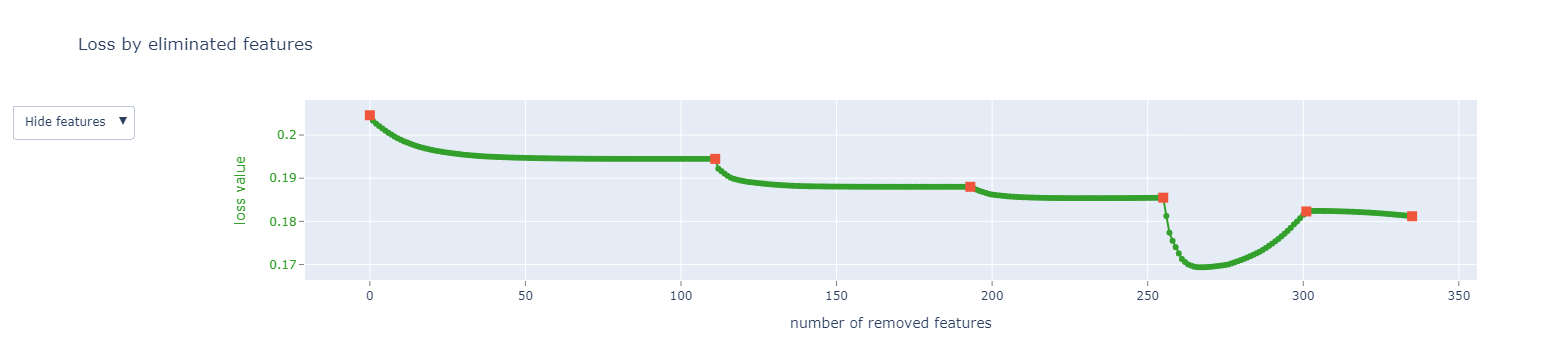

In [46]:
selected_features = summary['selected_features_names']
X_train = features_train[selected_features]
y_train = features_train.label
X_test = features_test[selected_features]
y_test = features_test.label

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6470464	test: 0.6470356	best: 0.6470356 (0)	total: 159ms	remaining: 7m 55s
1:	learn: 0.6098239	test: 0.6096862	best: 0.6096862 (1)	total: 167ms	remaining: 4m 11s
2:	learn: 0.5770682	test: 0.5771541	best: 0.5771541 (2)	total: 177ms	remaining: 2m 56s
3:	learn: 0.5497488	test: 0.5505593	best: 0.5505593 (3)	total: 185ms	remaining: 2m 18s
4:	learn: 0.5276766	test: 0.5289673	best: 0.5289673 (4)	total: 194ms	remaining: 1m 56s
5:	learn: 0.5086421	test: 0.5105233	best: 0.5105233 (5)	total: 201ms	remaining: 1m 40s
6:	learn: 0.4907651	test: 0.4932994	best: 0.4932994 (6)	total: 209ms	remaining: 1m 29s
7:	learn: 0.4753911	test: 0.4787927	best: 0.4787927 (7)	total: 217ms	remaining: 1m 21s
8:	learn: 0.4625282	test: 0.4668107	best: 0.4668107 (8)	total: 225ms	remaining: 1m 14s
9:	learn: 0.4473888	test: 0.4519922	best: 0.4519922 (9)	total: 233ms	remaining: 1m 9s
10:	learn: 0.4365260	test: 0.4413963	best: 0.4413963 (10)	total: 241ms	remaining: 1m 5s
11:	learn: 0.4257150	test: 0.4312399	best: 

In [47]:
predictions = model.predict(features_test.drop(columns=['label']))
labels = features_test.label.values[:,np.newaxis]

print('Test Accuracy {}'.format((predictions==labels).sum()/labels.shape[0]))

Test Accuracy 0.894927536231884


In [65]:
predictions = model.predict(hard_features_test.drop(columns=['label']))
labels = hard_features_test.label.values[:,np.newaxis]


print('Test Accuracy {}'.format((predictions==labels).sum()/labels.shape[0]))

Test Accuracy 0.2


In [83]:
model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.01,
    auto_class_weights='Balanced',
    reg_lambda=20.0,
    #bootstrap_type='MVS',
    grow_policy='Lossguide',
    depth=6,
    max_leaves=16,
    colsample_bylevel=0.5,
    loss_function='MultiClassOneVsAll'
)
summary = {}
summary['selected_features_names'] = features_train.drop(columns=['label']).columns.to_list()
selected_features = summary['selected_features_names']
X_train = features_train[selected_features]
y_train = features_train.label
X_test = features_test[selected_features]
y_test = features_test.label
X_test_hard = hard_features_test[selected_features]
y_test_hard = hard_features_test.label

model.fit(
    X_train, y_train,
    eval_set=(X_test_hard, y_test_hard),
    verbose=True,
    plot=True
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6815951	test: 0.6794171	best: 0.6794171 (0)	total: 1.74ms	remaining: 2.61s
1:	learn: 0.6732039	test: 0.6711958	best: 0.6711958 (1)	total: 2.67ms	remaining: 2s
2:	learn: 0.6663273	test: 0.6644712	best: 0.6644712 (2)	total: 3.41ms	remaining: 1.7s
3:	learn: 0.6606845	test: 0.6589652	best: 0.6589652 (3)	total: 4.13ms	remaining: 1.54s
4:	learn: 0.6543882	test: 0.6521491	best: 0.6521491 (4)	total: 5.91ms	remaining: 1.76s
5:	learn: 0.6467095	test: 0.6495895	best: 0.6495895 (5)	total: 7.9ms	remaining: 1.97s
6:	learn: 0.6410373	test: 0.6503016	best: 0.6495895 (5)	total: 9.83ms	remaining: 2.1s
7:	learn: 0.6361766	test: 0.6430719	best: 0.6430719 (7)	total: 11.7ms	remaining: 2.19s
8:	learn: 0.6292955	test: 0.6429724	best: 0.6429724 (8)	total: 13.7ms	remaining: 2.27s
9:	learn: 0.6258627	test: 0.6378503	best: 0.6378503 (9)	total: 15.7ms	remaining: 2.34s
10:	learn: 0.6188021	test: 0.6355106	best: 0.6355106 (10)	total: 17.5ms	remaining: 2.37s
11:	learn: 0.6153172	test: 0.6339168	best: 0.63

In [86]:
# predictions = model.predict(hard_features_test.drop(columns=['label']))
labels = hard_features_test.label.values[:,np.newaxis]


print('Test Accuracy {}'.format((predictions==labels).sum()/labels.shape[0]))

Test Accuracy 0.4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 5
0:	learn: 0.6919461	test: 0.6917270	best: 0.6917270 (0)	total: 4.7ms	remaining: 7.04s
1:	learn: 0.6909035	test: 0.6906868	best: 0.6906868 (1)	total: 5.49ms	remaining: 4.11s
2:	learn: 0.6898809	test: 0.6896665	best: 0.6896665 (2)	total: 6.28ms	remaining: 3.13s
3:	learn: 0.6888777	test: 0.6886656	best: 0.6886656 (3)	total: 7.24ms	remaining: 2.71s
4:	learn: 0.6878937	test: 0.6876838	best: 0.6876838 (4)	total: 8.07ms	remaining: 2.41s
5:	learn: 0.6869283	test: 0.6867207	best: 0.6867207 (5)	total: 8.88ms	remaining: 2.21s
6:	learn: 0.6859814	test: 0.6857759	best: 0.6857759 (6)	total: 9.66ms	remaining: 2.06s
7:	learn: 0.6850524	test: 0.6848491	best: 0.6848491 (7)	total: 10.5ms	remaining: 1.95s
8:	learn: 0.6841410	test: 0.6839399	best: 0.6839399 (8)	total: 11.2ms	remaining: 1.86s
9:	learn: 0.6832469	test: 0.6830480	best: 0.6830480 (9)	total: 12ms	remaining: 1.79s
10:	learn: 0.6823708	test: 0.6821615	best: 0.6821615 (10)	total: 15ms	remaining: 2.04s
11:	learn: 0.6815102	test: 0.

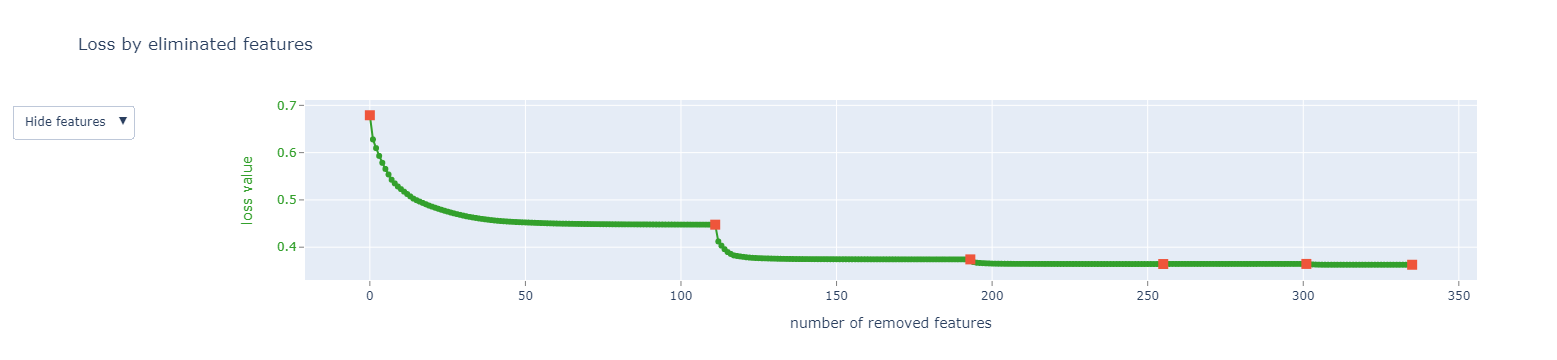

In [84]:
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.01,
    auto_class_weights='Balanced',
    reg_lambda=20.0,
    #bootstrap_type='MVS',
    grow_policy='Lossguide',
    depth=6,
    max_leaves=16,
    colsample_bylevel=0.5,
    loss_function='MultiClassOneVsAll'
)
summary = {}
summary['selected_features_names'] = features_train.drop(columns=['label']).columns.to_list()
summary = model.select_features(
        train_pool,
        eval_set=hard_test_pool,
        features_for_select=features_train.drop(columns=['label']).columns.to_list(),     # we will select from all features
        num_features_to_select=100,  # we want to select exactly important features
        steps=5,                                     # more steps - more accurate selection
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Verbose',
        plot=True
    )


In [85]:
from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix
cm = get_confusion_matrix(model, test_pool)
print(cm)

[[ 29.   3.   6.]
 [ 52. 327. 258.]
 [  3.  20. 130.]]


In [20]:
X_test[selected_features]

0  10  100  101  102  103  \
uid                                                                             
2aed8992313c4bf56a1cd5c0a7e3a0540ca577122c905bc...  0   0    0    0    0    0   
7e01fedc635ee3b247bdb7a32f9fb8417d1e8d6c62f352b...  0   0    0    0    0    0   
7fd72a36f7e0e6e0a8bc777fc9ed41e0a6d5526c98bc95a...  0   1    0    1    0    0   
85b6fb7cb99ee5f41e11c9284c2d75844e50c80cc18d90e...  0   0    0    0    0    0   
87e3bc282e94c58d04b0787eaa72da24897323c95431fd8...  0   1    0    0    0    0   
...                                                ..  ..  ...  ...  ...  ...   
fe73c1b35c624fb62c24fcd8c251723337eed4bbc8fa8bc...  0   0    0    0    0    0   
fe79e50ee31bca6e8d3059245685d432ac74dc34e1af023...  0   0    0    1    0    0   
ff1acaf720c65504c6c81f5c3cbcaa1f8fb0dd2aa66c3bd...  0   0    0    0    0    0   
ffab2280978392cce7a3966a2af30803f95af0e5f79345c...  0   0    0    0    0    0   
ffb0e35cfab750c8532f7d49deb8a71284fa420660710b8...  0   0    0    0    0    0   

                                                    104  105  106  107  ...  \
uid                                                                     ...   
2aed8992313c4bf56a1cd5c0a7e3a0540ca577122c905bc...    0    1    0    0  ...   
7e01fedc635ee3b247bdb7a32f9fb8417d1e8d6c62f352b...    0    0    0    0  ...   
7fd72a36f7e0e6e0a8bc777fc9ed41e0a6d5526c98bc95a...    0    1    0    0  ...   
85b6fb7cb99ee5f41e11c9284c2d75844e50c80cc18d90e...    0    1    1    0  ...   
87e3bc282e94c58d04b0787eaa72da24897323c95431fd8...    0    1    0    0  ...   
...                                                 ...  ...  ...  ...  ...   
fe73c1b35c624fb62c24fcd8c251723337eed4bbc8fa8bc...    0    0    0    0  ...   
fe79e50ee31bca6e8d3059245685d432ac74dc34e1af023...    0    1    1    0  ...   
ff1acaf720c65504c6c81f5c3cbcaa1f8fb0dd2aa66c3bd...    0    1    1    0  ...   
ffab2280978392cce7a3966a2af30803f95af0e5f79345c...    0    0    0    0  ...   
ffb0e35cfab750c8532f7d49deb8a71284fa420660710b8...    0    1    1    1  ...   

                                                    334  35  380  391  402  \
uid                                                                          
2aed8992313c4bf56a1cd5c0a7e3a0540ca577122c905bc...    0   0    0    0    1   
7e01fedc635ee3b247bdb7a32f9fb8417d1e8d6c62f352b...    0   0    0    0    1   
7fd72a36f7e0e6e0a8bc777fc9ed41e0a6d5526c98bc95a...    0   0    0    1    1   
85b6fb7cb99ee5f41e11c9284c2d75844e50c80cc18d90e...    0   0    0    0    1   
87e3bc282e94c58d04b0787eaa72da24897323c95431fd8...    1   0    1    0    1   
...                                                 ...  ..  ...  ...  ...   
fe73c1b35c624fb62c24fcd8c251723337eed4bbc8fa8bc...    0   0    0    0    1   
fe79e50ee31bca6e8d3059245685d432ac74dc34e1af023...    0   0    1    0    1   
ff1acaf720c65504c6c81f5c3cbcaa1f8fb0dd2aa66c3bd...    1   0    1    1    0   
ffab2280978392cce7a3966a2af30803f95af0e5f79345c...    0   0    1    0    1   
ffb0e35cfab750c8532f7d49deb8a71284fa420660710b8...    1   0    1    1    1   

                                                    413  424  46  57  68  
uid                                                                       
2aed8992313c4bf56a1cd5c0a7e3a0540ca577122c905bc...    1    0   1   0   1  
7e01fedc635ee3b247bdb7a32f9fb8417d1e8d6c62f352b...    1    0   1   0   1  
7fd72a36f7e0e6e0a8bc777fc9ed41e0a6d5526c98bc95a...    1    1   0   1   1  
85b6fb7cb99ee5f41e11c9284c2d75844e50c80cc18d90e...    1    0   0   0   1  
87e3bc282e94c58d04b0787eaa72da24897323c95431fd8...    1    0   0   0   1  
...                                                 ...  ...  ..  ..  ..  
fe73c1b35c624fb62c24fcd8c251723337eed4bbc8fa8bc...    1    1   0   0   1  
fe79e50ee31bca6e8d3059245685d432ac74dc34e1af023...    1    0   0   1   1  
ff1acaf720c65504c6c81f5c3cbcaa1f8fb0dd2aa66c3bd...    0    1   0   1   1  
ffab2280978392cce7a3966a2af30803f95af0e5f79345c...    1    0   0   0   1  
ffb0e35cfab750c8532f7d49deb8a71284fa420660710b8...    1

In [87]:
shap_values = model.get_feature_importance(Pool(X_test, y_test), type="ShapValues")

In [28]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

NameError: name 'expected_value' is not defined

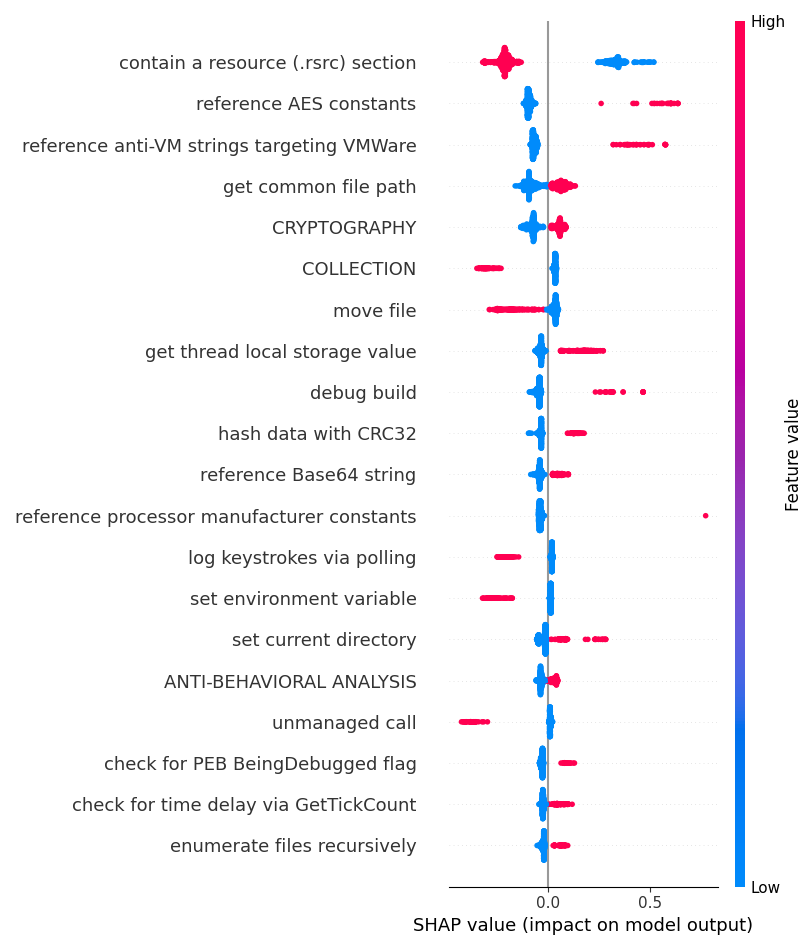

In [100]:
import shap
import matplotlib.pyplot as plt

plt.figure()
feature_names = features_encoder.inverse_transform([int(x) for x in X_test.columns])
shap.initjs()
shap.summary_plot(shap_values.transpose(1,0,2)[0,:,:-1], X_test.values,feature_names=feature_names)

In [99]:
le.inverse_transform([0,1,2])

array(['cozy', 'family', 'veno'], dtype=object)

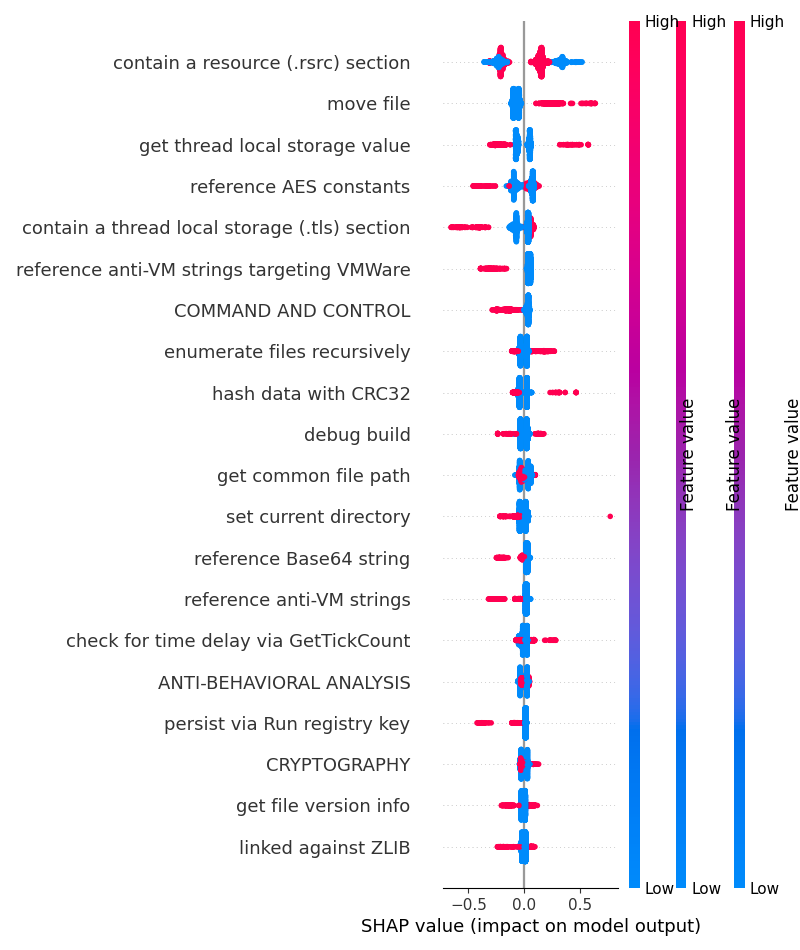

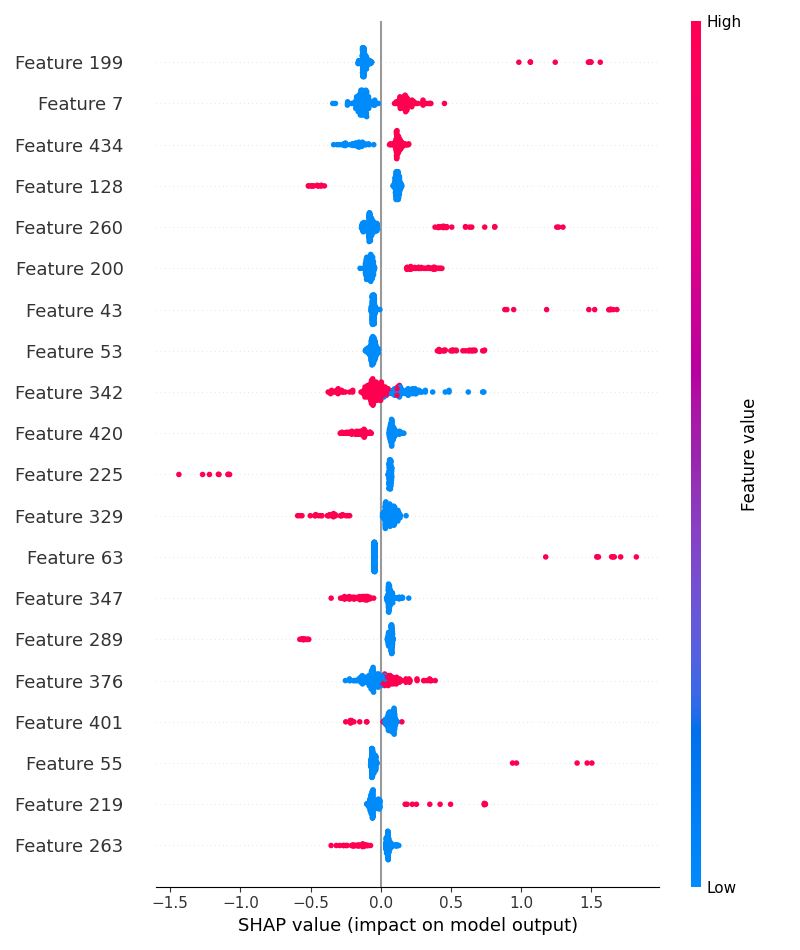

In [12]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=3000)
tsne_results = tsne.fit_transform(features_test.drop(columns=['label']))

c:\users\stav\virtualenvs\whodis\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\stav\virtualenvs\whodis\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 545 samples in 0.000s...
[t-SNE] Computed neighbors for 545 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 545 / 545
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.673325
[t-SNE] KL divergence after 3000 iterations: 0.055862


In [13]:

features_test['tsne-2d-one'] = tsne_results[:,0]
features_test['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    #palette=sns.color_palette("hls", 5),
    data=features_test,
    legend="full",
    alpha=0.3
)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

In [82]:
sns.color_palette("hls", 5)

[(0.86, 0.3712, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86)]

In [103]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=3000)
tsne_results = tsne.fit_transform(features_df.drop(columns=['label']))

c:\users\stav\virtualenvs\whodis\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\stav\virtualenvs\whodis\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2147 samples in 0.001s...
[t-SNE] Computed neighbors for 2147 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2147
[t-SNE] Computed conditional probabilities for sample 2000 / 2147
[t-SNE] Computed conditional probabilities for sample 2147 / 2147
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.791409
[t-SNE] KL divergence after 2950 iterations: 0.087856


In [107]:

features_df['tsne-2d-one'] = tsne_results[:,0]
features_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    #palette=sns.color_palette("hls", 5),
    data=features_df,
    legend="full",
    alpha=0.3
)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

In [106]:
!pip install ipython